# Benchmark

In [2]:
# ライブラリのインポート
import pandas as pd
import lightgbm as lgb
import warnings
import gc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
warnings.simplefilter('ignore')

In [3]:
# dataの読み込み
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submit_df = pd.read_csv('submit_sample.csv',header=None)

In [4]:
# データの量の確認
train_df.shape,test_df.shape,submit_df.shape

((27100, 18), (18050, 17), (18050, 2))

In [5]:
# 訓練データ、テストデータがわかるようにダミーの目的変数を代入
test_df['y']=-999

In [6]:
# 訓練データ、テストデータを結合
all_df = pd.concat([train_df,test_df])
del train_df,test_df
gc.collect()

20

In [7]:
# カテゴリカラムの前処理
categorical_features = ['job', 'marital', 'education','default','housing','loan','contact','month','poutcome']
for col in categorical_features:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(all_df[col])
    lbl.transform(all_df[col])
    all_df[col]=lbl.transform(all_df[col])

In [8]:
# 訓練データ、テストデータの分割
train_df = all_df[all_df['y']!=-999]
test_df = all_df[all_df['y']==-999]

In [9]:
y_train = train_df['y']
X_train = train_df.drop(['y','id'], axis=1)
X_test = test_df.drop(['y','id'], axis=1)

In [10]:
# 訓練データからデータを分割
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

In [11]:
# 使用モデルはLGB（パラメータチューニング無）
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

params = {
    'objective': 'binary'
}

model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=1000,
    early_stopping_rounds=10
)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.210006	valid_1's binary_logloss: 0.220314
[20]	training's binary_logloss: 0.191481	valid_1's binary_logloss: 0.209446
[30]	training's binary_logloss: 0.179046	valid_1's binary_logloss: 0.204832
[40]	training's binary_logloss: 0.169484	valid_1's binary_logloss: 0.203141
[50]	training's binary_logloss: 0.162016	valid_1's binary_logloss: 0.202679


In [12]:
y_pred

array([0.77141049, 0.14898476, 0.03111194, ..., 0.08560213, 0.00740139,
       0.15052081])

## まずは、いったんこれで算出した結果がどうなるか可視化してみる

In [13]:
## まずは訓練データで検証

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

In [15]:
y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
y_pred_valid

array([0.03580811, 0.22393526, 0.0240319 , ..., 0.4426737 , 0.01564351,
       0.03028361])

In [16]:
y_pred = y_pred_valid[0:100]
y_valid = y_valid[0:100]

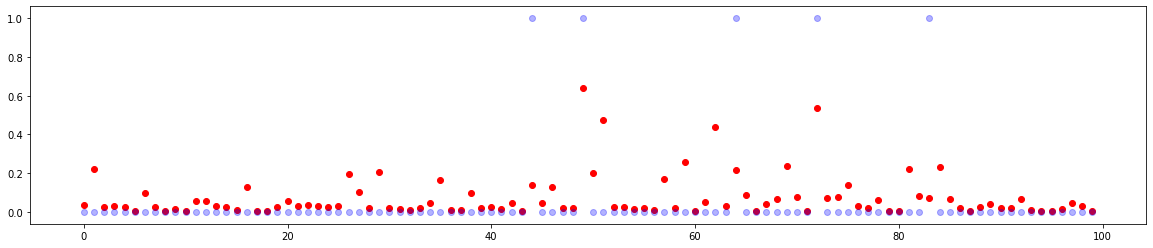

In [17]:
plt.figure(figsize=(20, 4))
plt.scatter(list(range(len(y_pred))), y_pred, color='red')
plt.scatter(list(range(len(y_valid))), y_valid.values, alpha=0.3, color='blue')

In [18]:
metrics.roc_auc_score(y_valid, y_pred)

0.9094736842105263

# ここからが今回学習するところ

In [19]:
y_train_origin = train_df['y']
X_train_origin = train_df.drop(['y','id'], axis=1)
X_test_origin = test_df.drop(['y','id'], axis=1)

In [20]:
output_df = pd.DataFrame()

for i in range(100):
    #訓練データからテストデータを分割
    X_train , X_valid , y_train , y_valid = train_test_split(X_train_origin,y_train_origin,test_size = 0.3 , random_state = i , stratify=y_train_origin)
    #使用モデルはLGB（パラメーターチューニングなし）
    lgb_train = lgb.Dataset(X_train,y_train,categorical_feature = categorical_features)
    lgb_eval = lgb.Dataset(X_valid , y_valid , reference = lgb_train , categorical_feature = categorical_features)
    params = {
        "objective":"binary"
    }

    model = lgb.train(
        params,lgb_train,
        valid_sets=[lgb_train,lgb_eval],
        verbose_eval = 10,
        num_boost_round = 1000,
        early_stopping_rounds=10
    )

    y_pred = model.predict(X_test_origin,num_iteration=model.best_iteration)
    output_df[i] = y_pred


[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.210006	valid_1's binary_logloss: 0.220314
[20]	training's binary_logloss: 0.191481	valid_1's binary_logloss: 0.209446
[30]	training's binary_logloss: 0.179046	valid_1's binary_logloss: 0.204832
[40]	training's binary_logloss: 0.169484	valid_1's binary_logloss: 0.203141
[50]	training's binary_logloss: 0.162016	valid_1's binary_logloss: 0.202679


[30]	training's binary_logloss: 0.180189	valid_1's binary_logloss: 0.202609
[40]	training's binary_logloss: 0.170985	valid_1's binary_logloss: 0.201685
[50]	training's binary_logloss: 0.162804	valid_1's binary_logloss: 0.200903
[60]	training's binary_logloss: 0.156578	valid_1's binary_logloss: 0.201061
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.160195	valid_1's binary_logloss: 0.200638
[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until validation 

[20]	training's binary_logloss: 0.190549	valid_1's binary_logloss: 0.209608
[30]	training's binary_logloss: 0.178634	valid_1's binary_logloss: 0.205281
[40]	training's binary_logloss: 0.169678	valid_1's binary_logloss: 0.203225
[50]	training's binary_logloss: 0.162141	valid_1's binary_logloss: 0.202603
[60]	training's binary_logloss: 0.155986	valid_1's binary_logloss: 0.202407
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.157741	valid_1's binary_logloss: 0.202151
[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until

[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.210308	valid_1's binary_logloss: 0.218143
[20]	training's binary_logloss: 0.191813	valid_1's binary_logloss: 0.206901
[30]	training's binary_logloss: 0.179851	valid_1's binary_logloss: 0.202308
[40]	training's binary_logloss: 0.170884	valid_1's binary_logloss: 0.201084
[50]	training's binary_logloss: 0.163317	valid_1's binary_logloss: 0.201118


[20]	training's binary_logloss: 0.191171	valid_1's binary_logloss: 0.20999
[30]	training's binary_logloss: 0.178757	valid_1's binary_logloss: 0.205895
[40]	training's binary_logloss: 0.169616	valid_1's binary_logloss: 0.203519
[50]	training's binary_logloss: 0.162311	valid_1's binary_logloss: 0.20297
[60]	training's binary_logloss: 0.156141	valid_1's binary_logloss: 0.202119
[70]	training's binary_logloss: 0.150304	valid_1's binary_logloss: 0.202006
[80]	training's binary_logloss: 0.145193	valid_1's binary_logloss: 0.201992
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.149218	valid_1's binary_logloss: 0.201848
[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of

[30]	training's binary_logloss: 0.179175	valid_1's binary_logloss: 0.204495
[40]	training's binary_logloss: 0.17006	valid_1's binary_logloss: 0.202312
[50]	training's binary_logloss: 0.162457	valid_1's binary_logloss: 0.202313
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.165728	valid_1's binary_logloss: 0.20183
[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.208743	va

[30]	training's binary_logloss: 0.1762	valid_1's binary_logloss: 0.210828
[40]	training's binary_logloss: 0.166764	valid_1's binary_logloss: 0.209182
[50]	training's binary_logloss: 0.158762	valid_1's binary_logloss: 0.208814
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.159347	valid_1's binary_logloss: 0.208679
[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.208483	va

[30]	training's binary_logloss: 0.179897	valid_1's binary_logloss: 0.201109
[40]	training's binary_logloss: 0.170484	valid_1's binary_logloss: 0.198969
[50]	training's binary_logloss: 0.163002	valid_1's binary_logloss: 0.198578
[60]	training's binary_logloss: 0.156408	valid_1's binary_logloss: 0.198555
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.158394	valid_1's binary_logloss: 0.19849
[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until validation s

[20]	training's binary_logloss: 0.190518	valid_1's binary_logloss: 0.211007
[30]	training's binary_logloss: 0.178267	valid_1's binary_logloss: 0.20548
[40]	training's binary_logloss: 0.168581	valid_1's binary_logloss: 0.20384
[50]	training's binary_logloss: 0.160873	valid_1's binary_logloss: 0.203263
[60]	training's binary_logloss: 0.154568	valid_1's binary_logloss: 0.203404
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.158954	valid_1's binary_logloss: 0.203153
[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[Light

[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.210925	valid_1's binary_logloss: 0.217336
[20]	training's binary_logloss: 0.192875	valid_1's binary_logloss: 0.206809
[30]	training's binary_logloss: 0.18075	valid_1's binary_logloss: 0.201899
[40]	training's binary_logloss: 0.171806	valid_1's binary_logloss: 0.200376
[50]	training's binary_logloss: 0.163882	valid_1's binary_logloss: 0.19965
[6

[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.211247	valid_1's binary_logloss: 0.216875
[20]	training's binary_logloss: 0.192282	valid_1's binary_logloss: 0.2069
[30]	training's binary_logloss: 0.179636	valid_1's binary_logloss: 0.202946
[40]	training's binary_logloss: 0.169926	valid_1's binary_logloss: 0.201332
[50]	training's binary_logloss: 0.162584	valid_1's binary_logloss: 0.200732
[6

[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.209317	valid_1's binary_logloss: 0.219869
[20]	training's binary_logloss: 0.190289	valid_1's binary_logloss: 0.209938
[30]	training's binary_logloss: 0.178045	valid_1's binary_logloss: 0.205823
[40]	training's binary_logloss: 0.168396	valid_1's binary_logloss: 0.204973
[50]	training's binary_logloss: 0.160335	valid_1's binary_logloss: 0.204572


[20]	training's binary_logloss: 0.189194	valid_1's binary_logloss: 0.214868
[30]	training's binary_logloss: 0.177015	valid_1's binary_logloss: 0.211002
[40]	training's binary_logloss: 0.167883	valid_1's binary_logloss: 0.209158
[50]	training's binary_logloss: 0.160507	valid_1's binary_logloss: 0.208785
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.162531	valid_1's binary_logloss: 0.208419
[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until validation 

[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.209023	valid_1's binary_logloss: 0.219478
[20]	training's binary_logloss: 0.190182	valid_1's binary_logloss: 0.210315
[30]	training's binary_logloss: 0.178173	valid_1's binary_logloss: 0.20626
[40]	training's binary_logloss: 0.169258	valid_1's binary_logloss: 0.205209
[50]	training's binary_logloss: 0.162092	valid_1's binary_logloss: 0.205646
E

In [21]:
output_df.mean(axis = 1)

0        0.826259
1        0.073341
2        0.031332
3        0.004073
4        0.042300
           ...   
18045    0.018109
18046    0.008078
18047    0.081957
18048    0.008301
18049    0.104220
Length: 18050, dtype: float64

## これは単に100回、random_stateを変更しながら繰り返してLightGBMを実行した結果の平均値をTEST結果とした。これでAUCが<<0.854>>となったらしい

# ここからはさらに上を目指すためにやったこと、、、らしい

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows' ,500)
pd.set_option('display.max_columns', 100)


In [23]:
train_df = pd.read_csv("train.csv")

In [24]:
train_df_org = train_df.copy()

In [25]:
train_df["month"]

0        nov
1        aug
2        nov
3        may
4        apr
        ... 
27095    may
27096    may
27097    jun
27098    may
27099    may
Name: month, Length: 27100, dtype: object

In [26]:
#monthはdayと結合するつもりなので数字に直しました
#今回のデータに12月は存在しません
month_dict = {"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}
train_df["month"] = train_df["month"].map(month_dict)

In [27]:
train_df["month"]

0        11
1         8
2        11
3         5
4         4
         ..
27095     5
27096     5
27097     6
27098     5
27099     5
Name: month, Length: 27100, dtype: int64

In [28]:
#年齢
#age
#60歳以上の扱いに悩んだので丸めました
#～59歳までは十代ごとに、60歳ちょうど、60歳より上に変換
age_list = list(train_df["age"])

new_age_list = []

for i in range(len(age_list)):
    if age_list[i] == 60:
        new_age_list.append(60)
    elif age_list[i] > 60:
        new_age_list.append(70)
    else:
        new_age_list.append(int(age_list[i]/10)*10)
train_df["age_round"] = new_age_list

In [29]:
train_df["age_round"], train_df['age']

(0        30
 1        20
 2        30
 3        30
 4        40
          ..
 27095    30
 27096    30
 27097    30
 27098    30
 27099    30
 Name: age_round, Length: 27100, dtype: int64,
 0        31
 1        29
 2        35
 3        31
 4        48
          ..
 27095    37
 27096    35
 27097    35
 27098    30
 27099    34
 Name: age, Length: 27100, dtype: int64)

In [30]:
train_df.describe()


,id,age,balance,day,month,duration,campaign,pdays,previous,y,age_round
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000
mean,13549.500000,36.073284,47682.901771,16.747565,6.001919,229.325387,1.775830,432.482399,0.085720,0.077934,32.493358
std,7823.240484,7.816417,31650.760036,8.569588,2.137665,204.939958,0.950045,252.150648,0.365889,0.268072,7.323010
min,0.000000,22.000000,-6847.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,20.000000
25%,6774.750000,31.000000,20015.750000,8.000000,5.000000,121.000000,1.000000,214.000000,0.000000,0.000000,30.000000
50%,13549.500000,33.000000,47624.000000,17.000000,5.000000,158.000000,1.000000,432.000000,0.000000,0.000000,30.000000
75%,20324.250000,37.000000,75330.000000,26.000000,7.000000,345.000000,2.000000,650.000000,0.000000,0.000000,30.000000
max,27099.000000,90.000000,102121.000000,31.000000,11.000000,3076.000000,5.000000,870.000000,3.000000,1.000000,70.000000


In [31]:
numeric_col_list = ["age","balance","duration","campaign","pdays","previous"]

categorical_col_list  = [categorical_feature for categorical_feature in train_df.columns if categorical_feature not in numeric_col_list]
categorical_col_list.remove("id")


In [32]:
#numericについては目的変数でグルーピングして統計量を算出
for target_col in numeric_col_list:
    print("\ntarget_col：",target_col)
    display(train_df.groupby("y")[target_col].describe())


target_col： age


,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,24988.0,35.876341,7.564353,24.0,31.0,33.0,37.0,90.0
1,2112.0,38.403409,10.056032,22.0,31.0,34.0,46.0,60.0



target_col： balance


,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,24988.0,47691.172203,31668.085023,-6847.0,19984.0,47721.0,75322.75,102121.0
1,2112.0,47585.050663,31452.346082,-6757.0,20342.5,46582.5,75423.25,102101.0



target_col： duration


,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,24988.0,231.131423,204.385639,0.0,121.0,158.0,345.0,3076.0
1,2112.0,207.957386,210.263042,0.0,101.0,158.0,177.0,1347.0



target_col： campaign


,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,24988.0,1.784296,0.953880,1.0,1.0,1.0,2.0,5.0
1,2112.0,1.675663,0.897607,1.0,1.0,1.0,2.0,4.0



target_col： pdays


,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,24988.0,432.490916,252.018980,-1.0,214.0,433.0,650.0,870.0
1,2112.0,432.381629,253.763276,-1.0,217.5,428.0,649.5,870.0



target_col： previous


,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,24988.0,0.065672,0.310772,0.0,0.0,0.0,0.0,3.0
1,2112.0,0.322917,0.717175,0.0,0.0,0.0,0.0,3.0


In [33]:
#categoricalについては目的変数でグルーピングしてカウント
for target_col in categorical_col_list:
    print("\ntarget_col：",target_col)
    display(train_df.groupby(["y",target_col])[target_col].count())


target_col： job


y  job          
0  admin.           2911
   blue-collar      5612
   entrepreneur     1060
   housemaid         686
   management       4883
   retired           836
   self-employed    1051
   services         2308
   student           249
   technician       4704
   unemployed        688
1  admin.            276
   blue-collar       345
   entrepreneur       95
   housemaid          68
   management        463
   retired           168
   self-employed     112
   services          163
   student           104
   technician        211
   unemployed        107
Name: job, dtype: int64


target_col： marital


y  marital 
0  divorced     2278
   married     16467
   single       6243
1  divorced      157
   married      1098
   single        857
Name: marital, dtype: int64


target_col： education


y  education
0  primary       3112
   secondary    14928
   tertiary      6033
   unknown        915
1  primary        217
   secondary     1027
   tertiary       704
   unknown        164
Name: education, dtype: int64


target_col： default


y  default
0  no         24978
   yes           10
1  no          2112
Name: default, dtype: int64


target_col： housing


y  housing
0  no          9812
   yes        15176
1  no          1469
   yes          643
Name: housing, dtype: int64


target_col： loan


y  loan
0  no      21656
   yes      3332
1  no       1995
   yes       117
Name: loan, dtype: int64


target_col： contact


y  contact  
0  cellular     17398
   telephone     1005
   unknown       6585
1  cellular      1749
   telephone       99
   unknown        264
Name: contact, dtype: int64


target_col： day


y  day
0  1         1
   2      1442
   3       707
   4       838
   5       149
   6       473
   7      1761
   8      1050
   9       280
   10        4
   11      288
   12      961
   13      530
   14      332
   15     1424
   16     1579
   17     1092
   18     1605
   19      123
   20     1597
   21     1282
   22      112
   23      249
   25      108
   26     1058
   27     4087
   28      957
   29       37
   30      859
   31        3
1  2        53
   3        99
   4        34
   5        50
   6        29
   7       158
   8        92
   9        96
   11       36
   12       99
   13       88
   14      103
   15       27
   16      102
   17      193
   18      127
   19       17
   20       96
   21       46
   22       12
   23       19
   25        8
   26      114
   27       42
   28       87
   29        1
   30      284
Name: day, dtype: int64


target_col： month


y  month
0  1          315
   2          922
   3          115
   4         1597
   5        10736
   6         2910
   7         3020
   8         3150
   9           19
   10          42
   11        2162
1  1           46
   2          161
   3           99
   4          408
   5          496
   6          176
   7          287
   8          231
   9            8
   10          55
   11         145
Name: month, dtype: int64


target_col： poutcome


y  poutcome
0  failure      2598
   other         786
   success       147
   unknown     21457
1  failure       119
   other          40
   success       311
   unknown      1642
Name: poutcome, dtype: int64


target_col： y


y  y
0  0    24988
1  1     2112
Name: y, dtype: int64


target_col： age_round


y  age_round
0  20            1226
   30           18923
   40            3054
   50            1383
   60             389
   70              13
1  20             220
   30            1227
   40             323
   50             185
   60             157
Name: age_round, dtype: int64

In [34]:
#平均値と中央値を可視化して確認
#yの01別で平均値、中央値
y0_df = train_df.query('y == 0')
y1_df = train_df.query('y == 1')

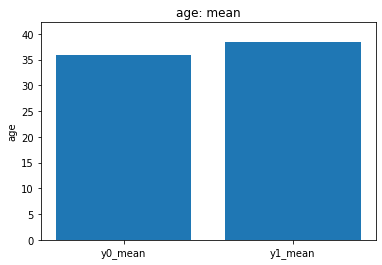

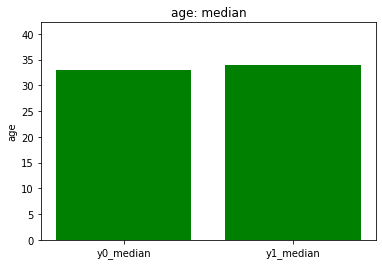

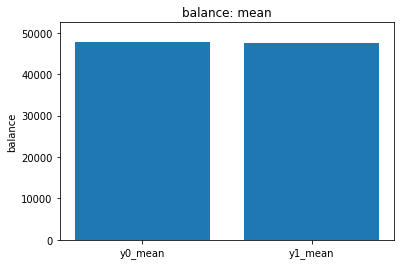

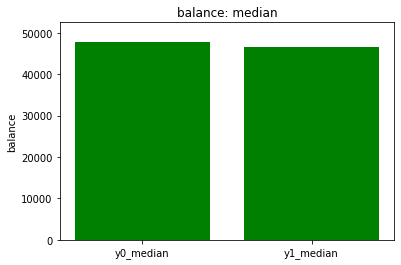

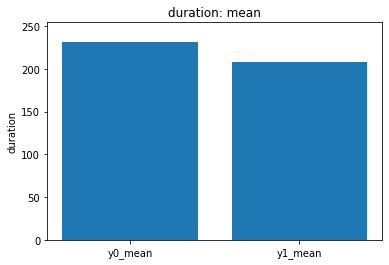

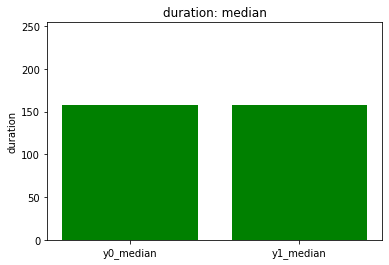

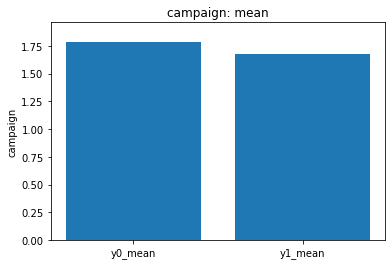

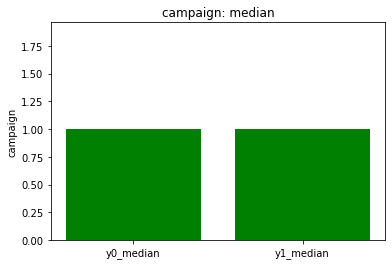

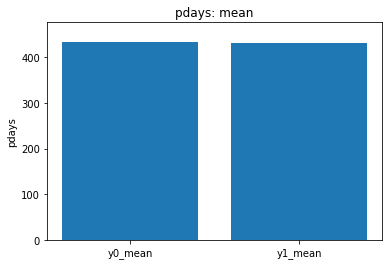

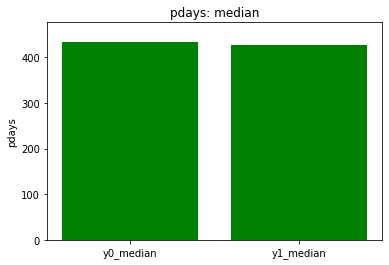

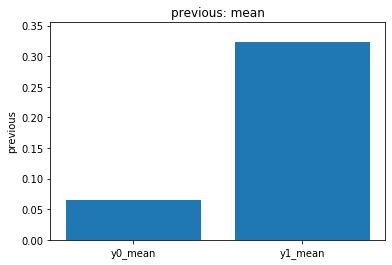

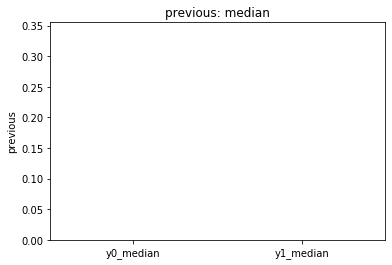

In [35]:
for target_col in numeric_col_list:

    #0,1別平均値
    y0_target_col_mean = y0_df[target_col].mean()
    y1_target_col_mean = y1_df[target_col].mean()

    #0,1別中央値
    y0_target_col_median = y0_df[target_col].median()
    y1_target_col_median = y1_df[target_col].median()

    #縦軸設定
    #平均値、中央値のうち最大値の1.1倍を縦軸とする
    #倍率は見やすければ何でもよい
    graph_y_length = (1.1*max(y0_target_col_mean,y1_target_col_mean,y0_target_col_median,y1_target_col_median))

    plt.title(target_col + ": mean")
    plt.ylabel(target_col)
    plt.ylim([0,graph_y_length],)
    plt.bar(["y0_mean","y1_mean"],[y0_target_col_mean,y1_target_col_mean])
    #plt.annotate(y0_target_col_mean,y0_target_col_mean)
    plt.show()

    plt.title(target_col + ": median")
    plt.ylabel(target_col)
    plt.ylim([0,graph_y_length],)
    plt.bar(["y0_median","y1_median"],[y0_target_col_median,y1_target_col_median],color = "green")
    plt.show()


y0 age


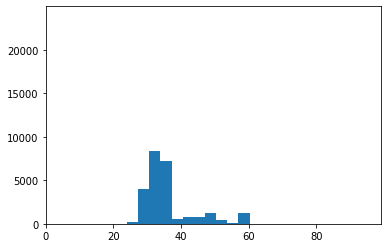

y1 age


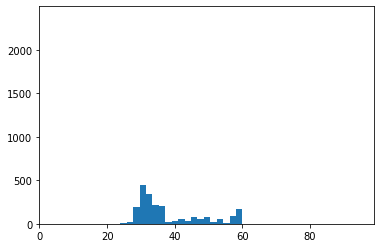

y0 balance


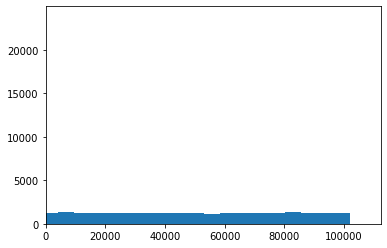

y1 balance


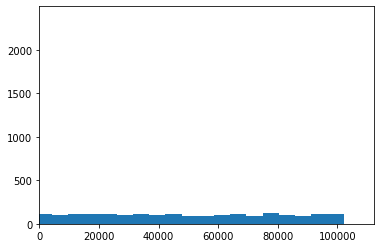

y0 duration


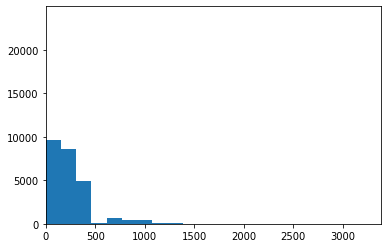

y1 duration


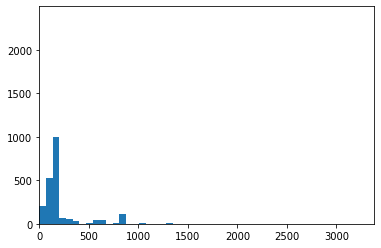

y0 campaign


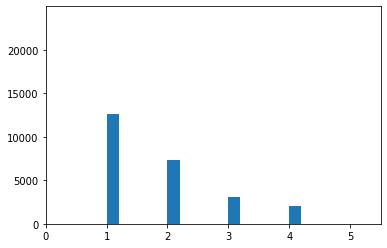

y1 campaign


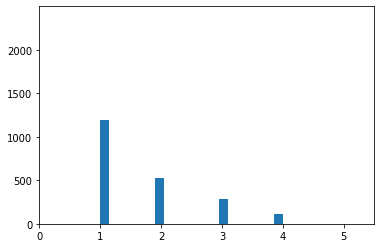

y0 pdays


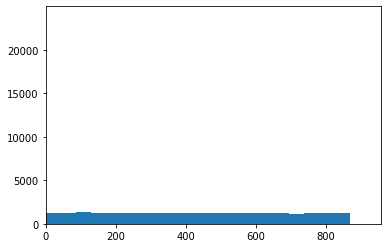

y1 pdays


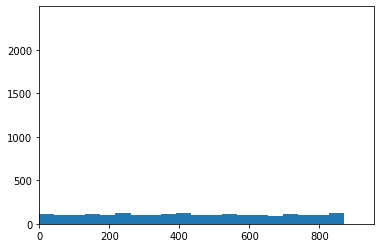

y0 previous


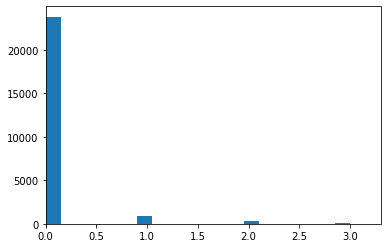

y1 previous


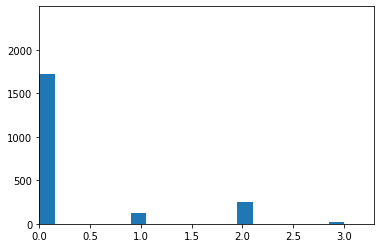

In [36]:
#ヒストグラムでも全体像把握
for target_col in numeric_col_list:
    #軸の設定
    graph_x_length = 1.1*max(train_df[target_col])
    graph_y_length = len(y0_df)

    print("y0",target_col)
    plt.xlim([0,graph_x_length],)
    plt.ylim([0,graph_y_length],)
    plt.hist(y0_df[target_col],bins = 20)
    plt.show()

    graph_y_length = graph_y_length/10
    print("y1",target_col)
    plt.xlim([0,graph_x_length],)
    plt.ylim([0,graph_y_length],)
    plt.hist(y1_df[target_col],bins = 20)
    plt.show()

In [37]:
#相関係数算出
train_df.corr()

,id,age,balance,day,month,duration,campaign,pdays,previous,y,age_round
id,1.000000,0.008676,0.002334,-0.001724,0.003756,-0.001855,-0.007897,0.001369,-0.003045,0.002318,0.010432
age,0.008676,1.000000,-0.001185,-0.059669,0.105084,-0.055642,0.037633,0.008551,0.037545,0.086668,0.931341
balance,0.002334,-0.001185,1.000000,0.003816,-0.004632,0.003144,-0.001229,0.003018,0.009717,-0.000899,0.000427
day,-0.001724,-0.059669,0.003816,1.000000,-0.079510,0.134440,-0.060326,-0.000433,-0.048624,-0.011804,-0.058463
month,0.003756,0.105084,-0.004632,-0.079510,1.000000,-0.140541,0.113377,0.001434,-0.041304,-0.049524,0.099008
duration,-0.001855,-0.055642,0.003144,0.134440,-0.140541,1.000000,-0.094643,0.003804,-0.015184,-0.030313,-0.052068
campaign,-0.007897,0.037633,-0.001229,-0.060326,0.113377,-0.094643,1.000000,-0.003626,-0.038244,-0.030653,0.039394
pdays,0.001369,0.008551,0.003018,-0.000433,0.001434,0.003804,-0.003626,1.000000,0.002187,-0.000116,0.002858
previous,-0.003045,0.037545,0.009717,-0.048624,-0.041304,-0.015184,-0.038244,0.002187,1.000000,0.188473,0.048863
y,0.002318,0.086668,-0.000899,-0.011804,-0.049524,-0.030313,-0.030653,-0.000116,0.188473,1.000000,0.078462


In [38]:
#目的変数の相関係数だけピックアップ
train_df.corr()["y"]

id           0.002318
age          0.086668
balance     -0.000899
day         -0.011804
month       -0.049524
duration    -0.030313
campaign    -0.030653
pdays       -0.000116
previous     0.188473
y            1.000000
age_round    0.078462
Name: y, dtype: float64

In [ ]:
import pandas as pd
import optuna
import functools
import warnings
warnings.simplefilter('ignore')


from sklearn.model_selection import train_test_split

#こいつがマジで有能
import optuna.integration.lightgbm as lgb

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

%matplotlib 


#dataの読み込み
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submit_df = pd.read_csv("submit_sample.csv",header = None)


#訓練データ、テストデータがわかるようにダミーの目的変数を代入
test_df["y"] = -999

#訓練データ、テストデータを結合
all_df = pd.concat([train_df,test_df])
del train_df , test_df

all_df.reset_index(inplace=True)


#月末フラグ
month_list = list(all_df["month"])
day_list = list(all_df["day"])

end_of_month_flag = []
for i in range(len(all_df)):
    if day_list[i] in [30,31]:
        end_of_month_flag.append(1)
    elif day_list[i] == 29 and month_list[i] in ["feb","apr","jun","sep","nov"]:
        end_of_month_flag.append(1)
    elif day_list[i] == 28 and month_list[i] == "feb":
        end_of_month_flag.append(1)
    else:
        end_of_month_flag.append(0)

all_df["end_of_month_flag"] = end_of_month_flag


#月(month列)を数値に変換
month_dict = {"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}
month_int = [month_dict[all_df["month"][i]] for i in range(len(all_df))]
all_df["month"] = month_int

#month_day列作成
#決定木は大小関係さえわかればいいのでintのまま扱って問題ないと思っています
month_day = []
month_day = all_df["month"]*100 + all_df["day"]
all_df["month_day"] = month_day

#不要列削除
del all_df["index"]
del all_df["id"]
del all_df["pdays"]
del all_df["balance"]

#カテゴリカルのカラム名を指定
categorical_features = ["job","marital","education","default","housing","loan","contact","month","poutcome","end_of_month_flag"]


#ラベルエンコード
#target encodingもしましたがスコアは変わらなかったです

for col in categorical_features:
  lbl = preprocessing.LabelEncoder()
  lbl.fit(all_df[col])
  lbl.transform(all_df[col])
  all_df[col] = lbl.transform(all_df[col])


#訓練データ、テストデータの分割
train_df = all_df[all_df["y"] != -999]
test_df = all_df[all_df["y"] == -999]

#説明変数と目的変数に分ける
origin_y_train = train_df["y"]
origin_X_train = train_df.drop(["y"],axis = 1)
origin_X_test = test_df.drop(["y"],axis = 1)

output_df = pd.DataFrame()


Using matplotlib backend: Qt5Agg


In [ ]:
##ここから先の実行は私のPC(第10世代corei5 メモリ8GB)では10数時間かかりました

for i in range(100):
    #訓練データからテストデータを分割
    X_train , X_valid , y_train , y_valid = train_test_split(origin_X_train,origin_y_train,test_size = 0.3 , random_state = i , stratify=origin_y_train)
    #データセット作成
    lgb_train = lgb.Dataset(X_train,y_train,categorical_feature = categorical_features,free_raw_data=False)
    lgb_eval = lgb.Dataset(X_valid , y_valid , reference = lgb_train , categorical_feature = categorical_features,free_raw_data=False)
    params ={"objective":"binary",
             "metric":"auc",
             'force_col_wise': 'true',
    }

    best_params, tuning_history = dict(), list()
    booster = lgb.train(params, lgb_train, valid_sets=[lgb_train,lgb_eval],
                        verbose_eval=0,
                        best_params=best_params,
                        tuning_history=tuning_history)

    print("Best Params:", best_params)
    print("Tuning history:", tuning_history)

    #最もAUCの高いハイパーパラメーターを追加
    params.update(best_params)

    #学習
    model = lgb.train(
        params,lgb_train,
        valid_sets=[lgb_train,lgb_eval],
        verbose_eval = 10,
        num_boost_round = 1000,
        early_stopping_rounds=10
    )

    #コンペデータで予測
    y_pred = model.predict(origin_X_test,num_iteration=model.best_iteration)

    output_df[i] = y_pred
